In [18]:
# let's try using linear regression to predict the label using the irregularity score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

# Create a support vector classifier
from sklearn.svm import SVC

# Create a Bayesian optimization
from bayes_opt import BayesianOptimization

# visualize using pairplot
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# load the results
pan_tompkins_results = pd.read_csv('results/mit_bih_pan_tomkins_features.csv')
pan_tompkins_results = pan_tompkins_results.dropna().drop('record_name', axis=1)
print('results shape:', pan_tompkins_results.shape)

results shape: (500, 14)


In [27]:
labels = pan_tompkins_results['label']
print(labels.value_counts())

label
N    100
S    100
V    100
F    100
Q    100
Name: count, dtype: int64


In [28]:
from sklearn.preprocessing import StandardScaler

# remove nan values
pan_tompkins_results = pan_tompkins_results.dropna()

# remove pnn50 as it is  not correct
pan_tompkins_results = pan_tompkins_results.drop(columns=['pnn50'])

# scale all the features
# scaler = StandardScaler()
# pan_tompkins_results[['rr_std', 'hr_std', 'signal_power', 'signal_entropy']] = scaler.fit_transform(pan_tompkins_results[['rr_std', 'hr_std', 'signal_power', 'signal_entropy']])

# lets print the columns
print(pan_tompkins_results.columns)
display(pan_tompkins_results.head())

# split the data into train and test
X, y = pan_tompkins_results.drop('label', axis=1), pan_tompkins_results['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = X.columns


Index(['rr_mean', 'rr_std', 'rmssd', 'hr_mean', 'hr_std', 'min_hr', 'max_hr',
       'signal_power', 'signal_entropy', 'irregularity_mean',
       'irregularity_std', 'rr_coefficient', 'label'],
      dtype='object')


rr_mean    rr_std     rmssd    hr_mean    hr_std     min_hr     max_hr  \
0  0.822500  0.023715  0.822842  60.840255  1.208851  59.358218  62.939115   
1  0.807828  0.026612  0.808267  61.960830  1.382845  59.961712  64.366881   
2  0.817172  0.027647  0.817639  61.255365  1.273002  58.929743  62.951063   
3  0.818333  0.019452  0.818564  61.134978  1.160438  59.868870  63.167664   
4  0.807071  0.023788  0.807421  62.005106  1.239186  59.486375  63.604770   

   signal_power  signal_entropy  irregularity_mean  irregularity_std  \
0      0.026343       93.718529           0.822500          0.023715   
1      0.029220       95.685380           0.807828          0.026612   
2      0.027858       96.570941           0.817172          0.027647   
3      0.029531       97.043588           0.818333          0.019452   
4      0.025884       99.866994           0.807071          0.023788   

   rr_coefficient label  
0        0.028833     N  
1        0.032943     N  
2        0.033832     N  
3        0.023771     N  
4        0.029475     N

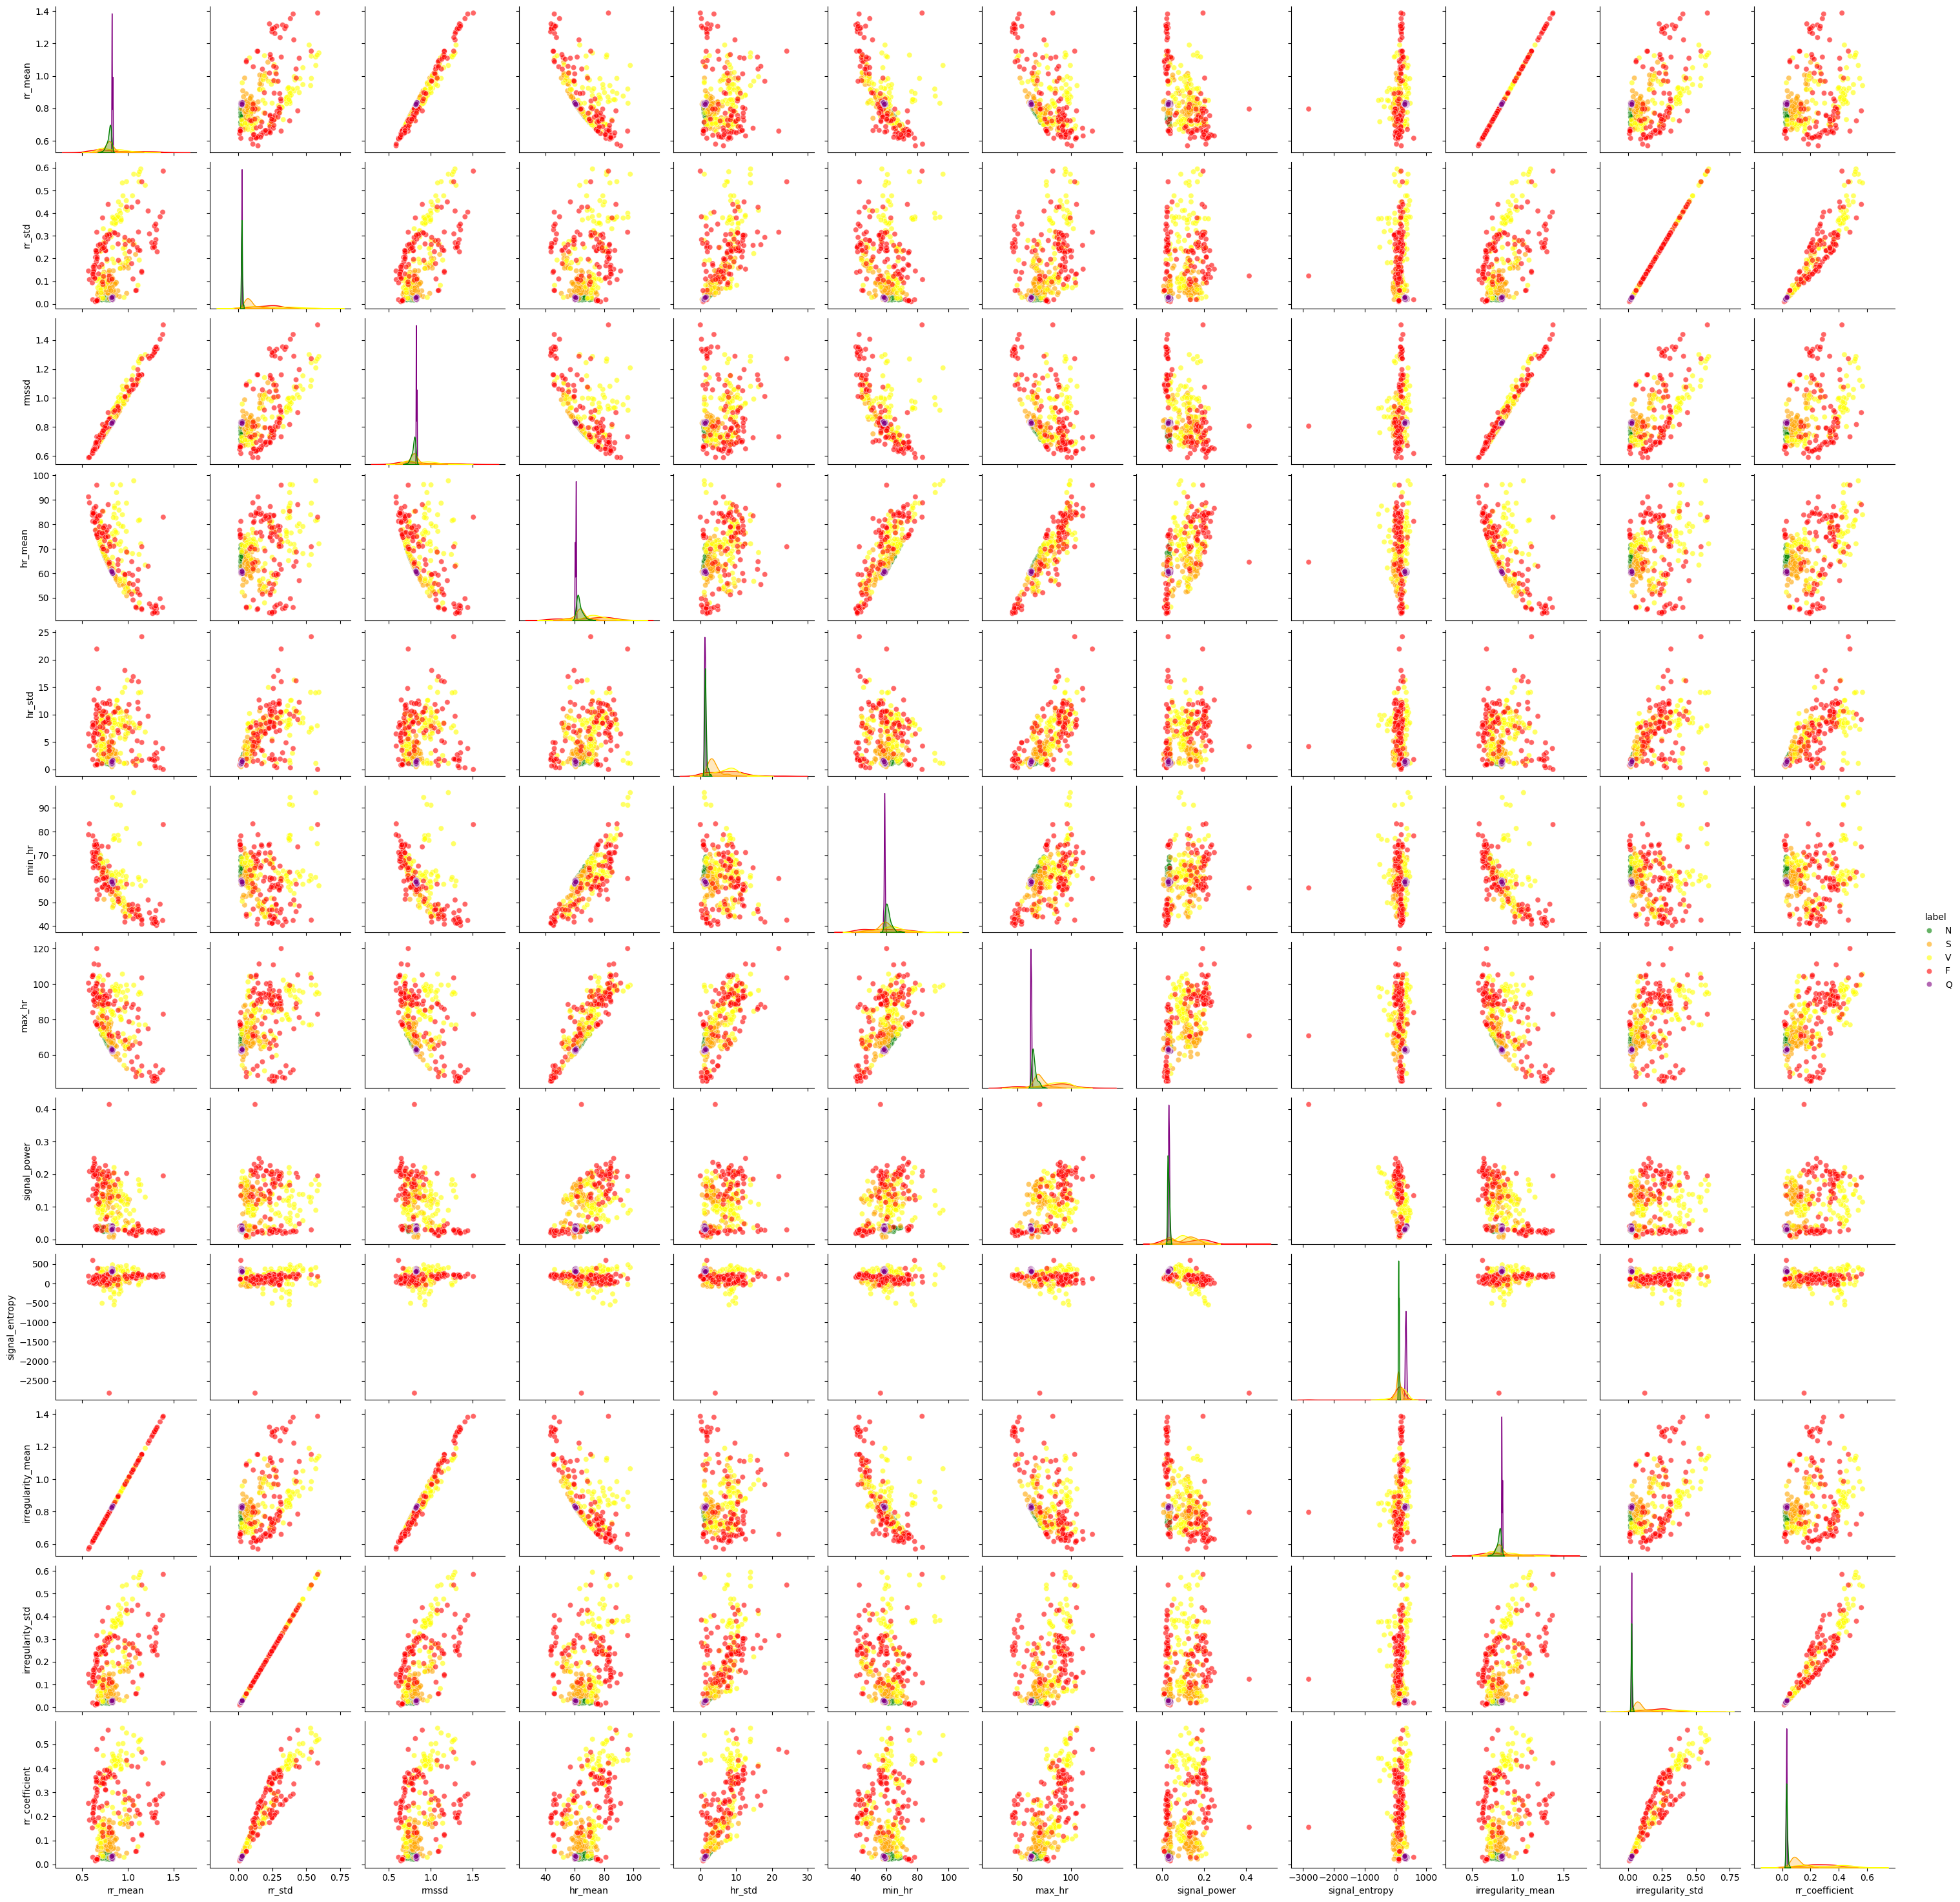

In [32]:

sns.pairplot(pan_tompkins_results[:500], hue='label', diag_kind='kde', 
             palette={'N': 'green', 'S': 'orange', 'V': 'yellow', 'F': 'red', 'Q': 'purple'},              
             plot_kws={'alpha': 0.6})
plt.show()

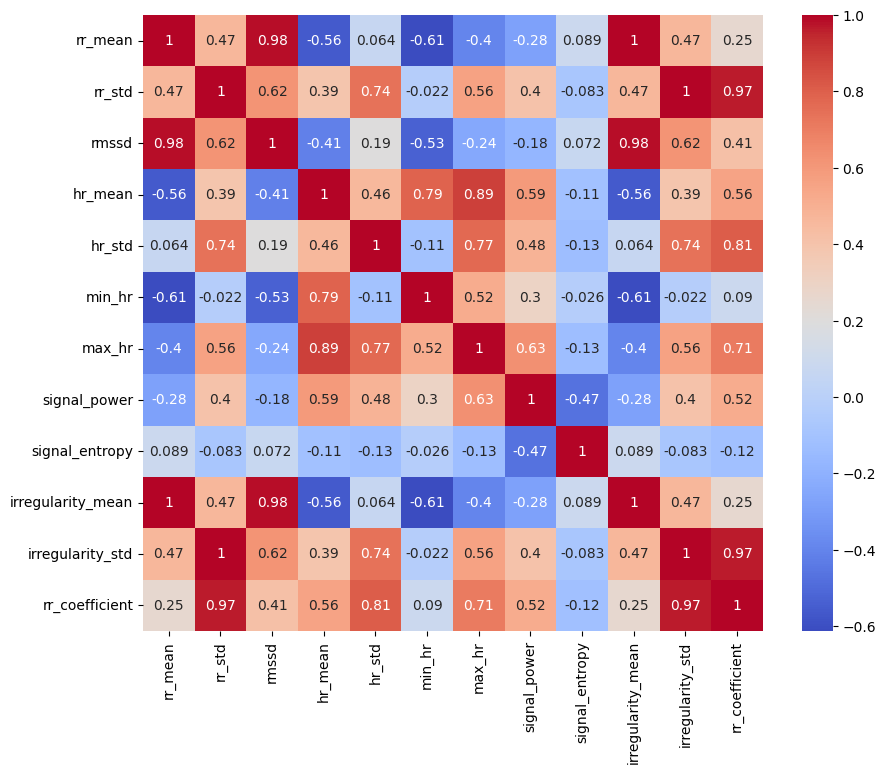

In [33]:
# plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pan_tompkins_results.drop(columns=['label']).corr(), annot=True, cmap='coolwarm')
plt.show()

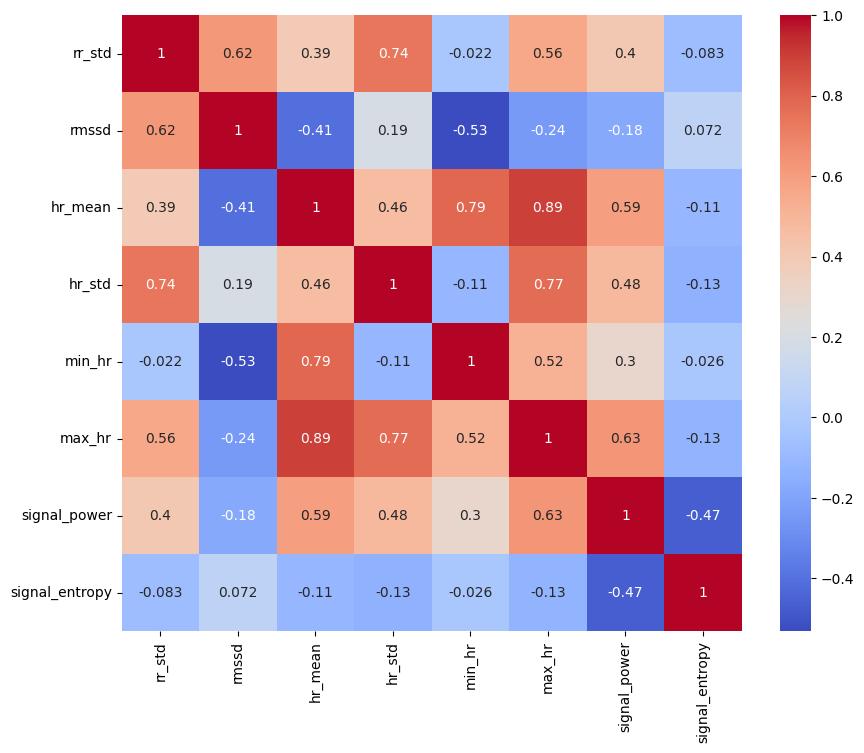

In [34]:
# remove highly correlated features
pan_tompkins_results = pan_tompkins_results.drop(columns=['irregularity_mean', 'irregularity_std', 'rr_coefficient', 'rr_mean'])
plt.figure(figsize=(10, 8))
sns.heatmap(pan_tompkins_results.drop(columns=['label']).corr(), annot=True, cmap='coolwarm')
plt.show()

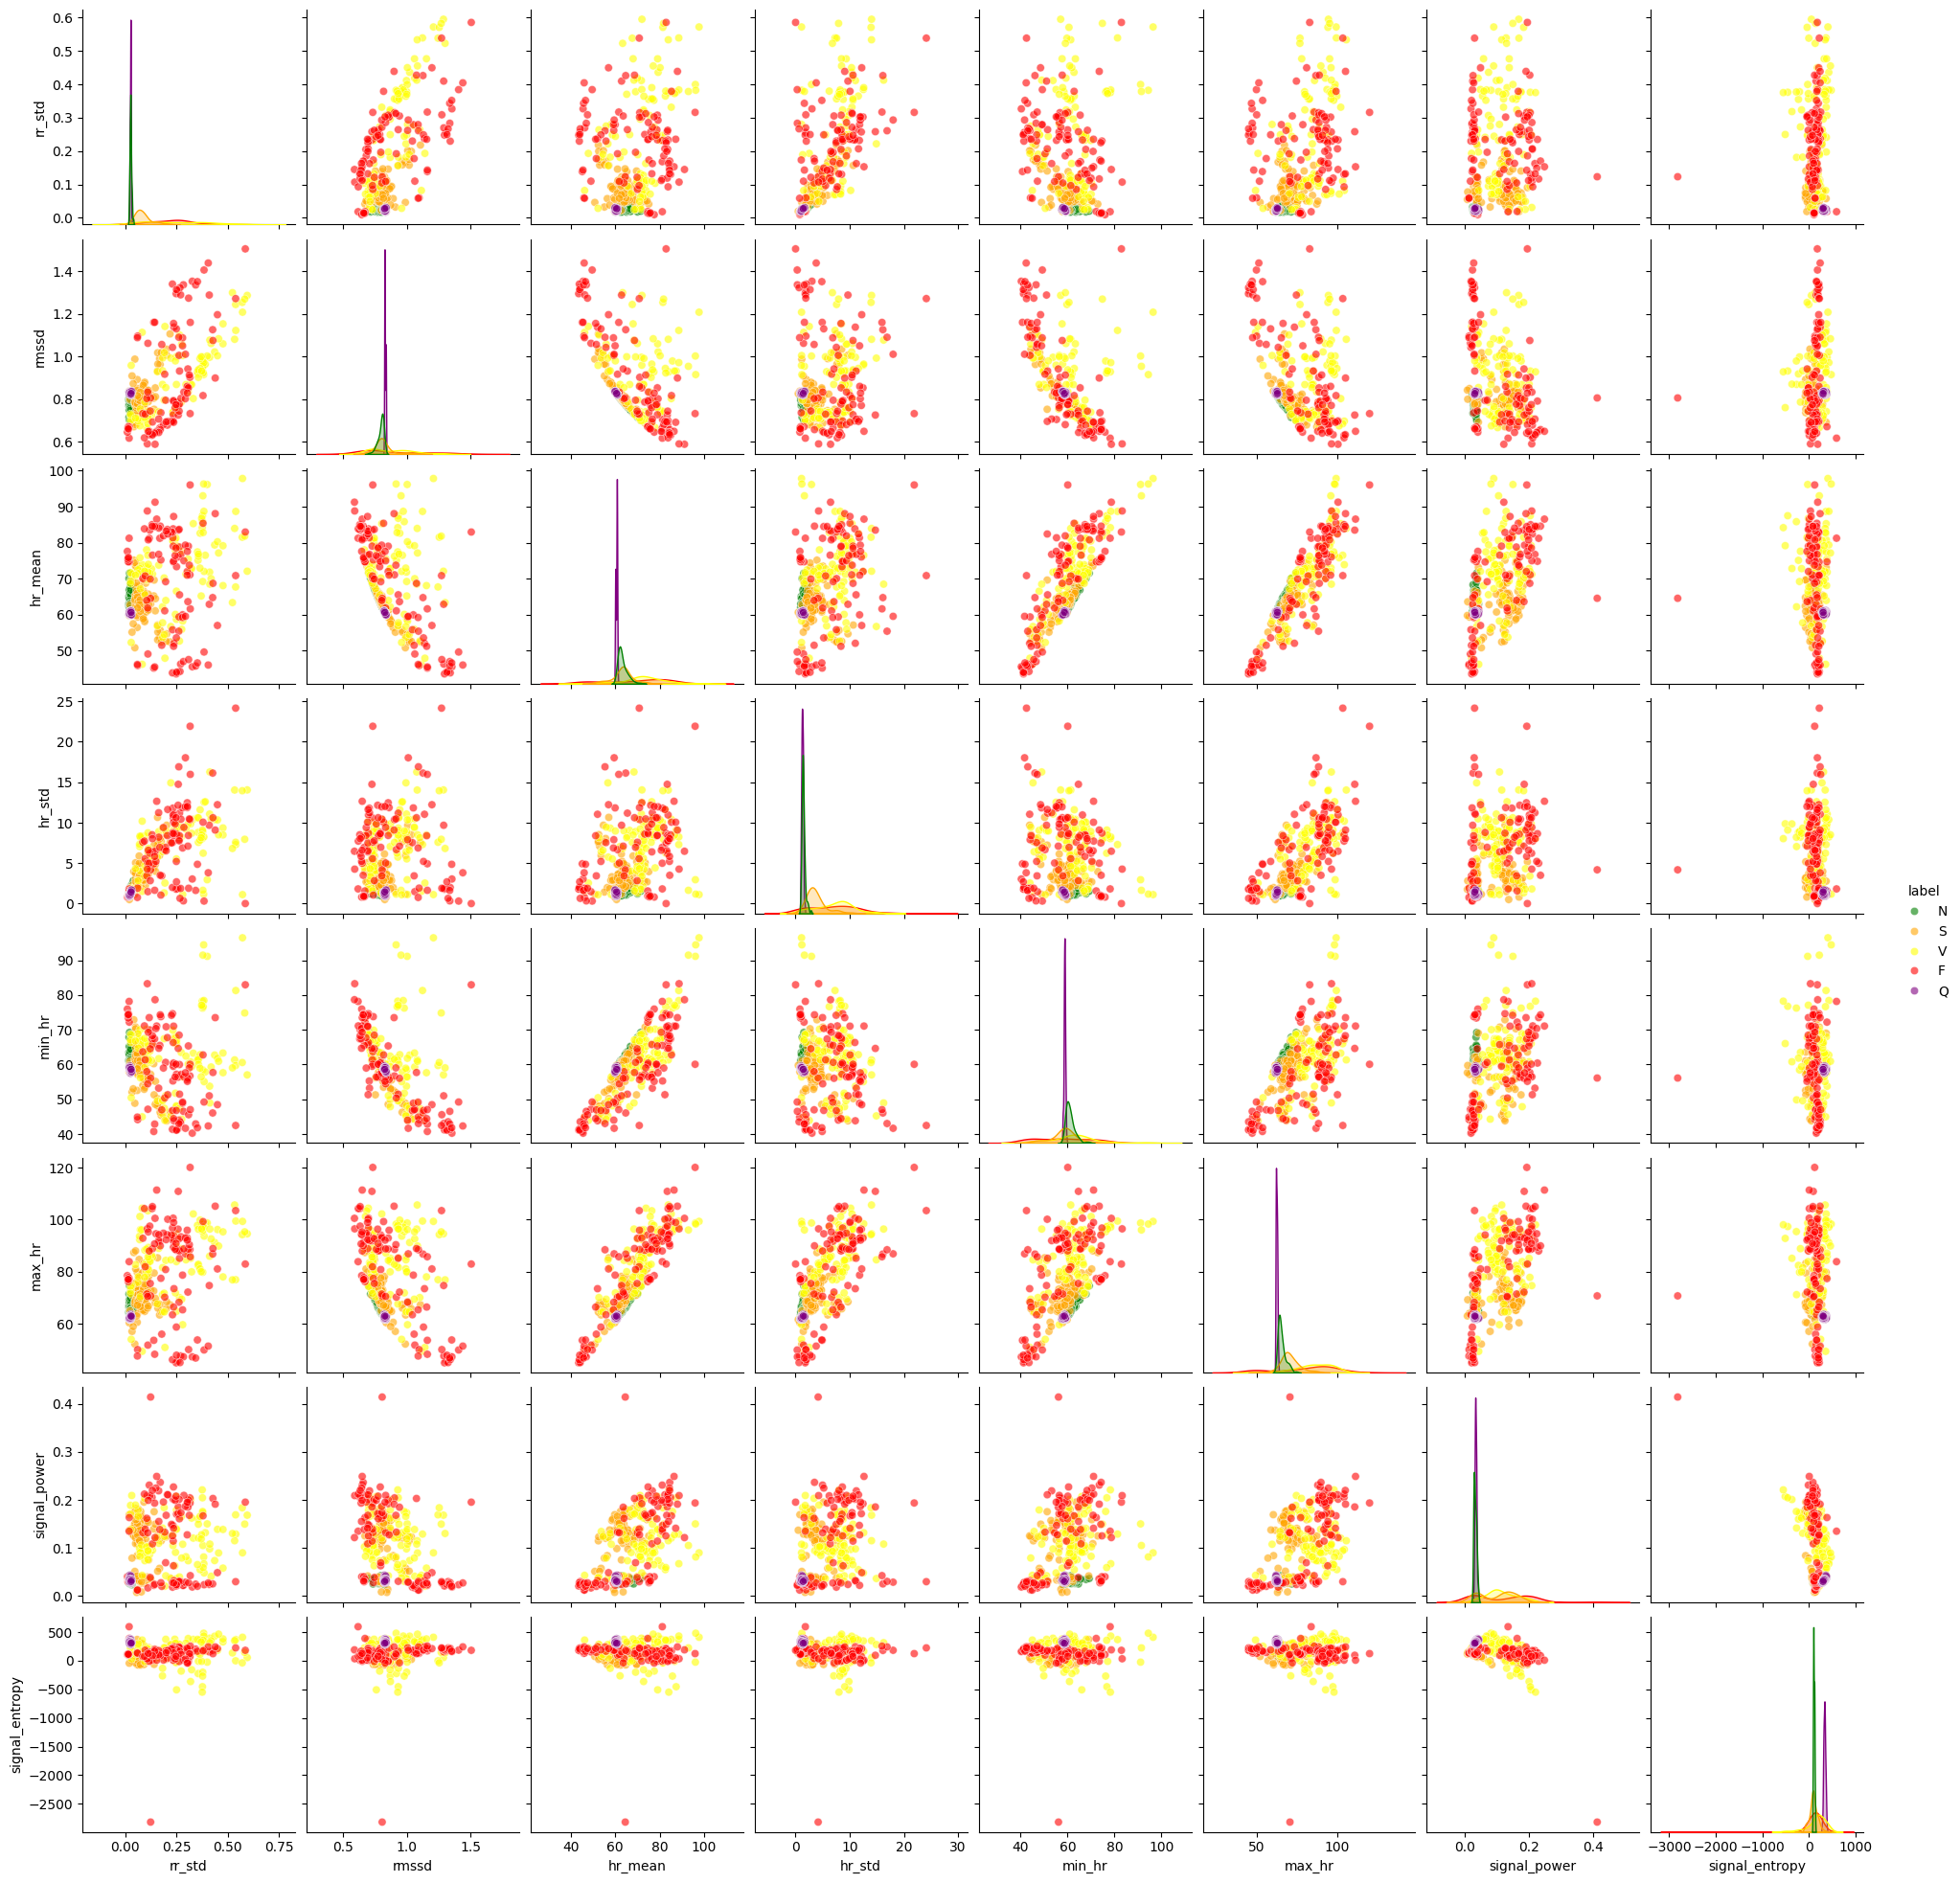

In [36]:
sns.pairplot(pan_tompkins_results[:500], hue='label', diag_kind='kde', 
             palette={'N': 'green', 'S': 'orange', 'V': 'yellow', 'F': 'red', 'Q': 'purple'},              
             plot_kws={'alpha': 0.6})
plt.show()

In [37]:
results = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy', 'Runtime', 'Top Predictor' ])
start_time = time.time()
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_train_score = accuracy_score(y_train, lr.predict(X_train))
lr_test_score = accuracy_score(y_test, lr.predict(X_test))
lr_runtime = time.time() - start_time
top_predictor = X.columns[np.argmax(np.abs(lr.coef_[0]))]
result = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Train Score': [lr_train_score],
    'Test Score': [lr_test_score],
    'Runtime': [lr_runtime],
    'Top Predictor': [top_predictor]
})
print(result)
result = pd.concat([result], ignore_index=True)


                 Model  Train Score  Test Score   Runtime Top Predictor
0  Logistic Regression       0.7175        0.74  0.068657        min_hr


/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
start_time = time.time()
# Create a logistic regression model L2
logreg2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
# Fit the model
logreg2.fit(X_train, y_train)
# Predict the target variable
y_pred2 = logreg2.predict(X_test)
# Calculate the accuracy
accuracy2 = accuracy_score(y_test, y_pred2)
# Calculate the runtime
runtime2 = time.time() - start_time
# Get the top predictor
# Append the results
result2 = pd.DataFrame({
    'Model': ['Logistic Regression L2'],
    'Train Accuracy': [logreg2.score(X_train, y_train)],
    'Test Accuracy': [accuracy2],
    'Runtime': [runtime2],
})
print(result2)
results = pd.concat([results, result2], ignore_index=True)

                    Model  Train Accuracy  Test Accuracy   Runtime
0  Logistic Regression L2            0.75           0.77  0.016993


/var/folders/3v/t7p60tvs5773q0xm_4_bb2tr0000gn/T/ipykernel_52355/3180948485.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result2], ignore_index=True)


In [40]:
from sklearn.calibration import LinearSVC


start_time = time.time()
# Create a linear SVM model
svm = LinearSVC(random_state=42)
# Fit the model
svm.fit(X_train, y_train)
# Predict the target variable
y_pred_svm = svm.predict(X_test)
# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
# Calculate the runtime
runtime_svm = time.time() - start_time

# Append the results
result_svm = pd.DataFrame({
    'Model': ['Linear SVM'],
    'Train Accuracy': [svm.score(X_train, y_train)],
    'Test Accuracy': [accuracy_svm],
    'Runtime': [runtime_svm],
})
print(result_svm)
results = pd.concat([results, result_svm], ignore_index=True)

        Model  Train Accuracy  Test Accuracy  Runtime
0  Linear SVM          0.7925            0.8  0.00633


In [41]:
# Create a random forest model
rf = RandomForestClassifier(random_state=42)
# Fit the model
rf.fit(X_train, y_train)
# Predict the target variable
y_pred_rf = rf.predict(X_test)
# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# Calculate the runtime
runtime_rf = time.time() - start_time
# Get the top predictor
top_predictor_rf = feature_names[np.argmax(rf.feature_importances_)]
# Append the results
result_rf = pd.DataFrame({
    'Model': ['Random Forest'],
    'Train Accuracy': [rf.score(X_train, y_train)],
    'Test Accuracy': [accuracy_rf],
    'Runtime': [runtime_rf],
    'Top Predictor': [top_predictor_rf]
})
print(result_rf)
results = pd.concat([results, result_rf], ignore_index=True)

           Model  Train Accuracy  Test Accuracy   Runtime   Top Predictor
0  Random Forest             1.0            0.9  4.589151  rr_coefficient


In [42]:
# Create a gradient boosting model
gb = GradientBoostingClassifier(random_state=42)
# Fit the model
gb.fit(X_train, y_train)
# Predict the target variable
y_pred_gb = gb.predict(X_test)
# Calculate the accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
# Calculate the runtime
runtime_gb = time.time() - start_time
# Get the top predictor
top_predictor_gb = feature_names[np.argmax(gb.feature_importances_)]
# Append the results
result_gb = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Train Accuracy': [gb.score(X_train, y_train)],
    'Test Accuracy': [accuracy_gb],
    'Runtime': [runtime_gb],
    'Top Predictor': [top_predictor_gb]
})
print(result_gb)
results = pd.concat([results, result_gb], ignore_index=True)

               Model  Train Accuracy  Test Accuracy   Runtime   Top Predictor
0  Gradient Boosting             1.0           0.92  7.245189  signal_entropy


In [43]:
# Display all the results as a table
display(results)

Model  Train Accuracy  Test Accuracy   Runtime  \
0  Logistic Regression L2          0.7500           0.77  0.016993   
1              Linear SVM          0.7925           0.80  0.006670   
2              Linear SVM          0.7925           0.80  0.006330   
3           Random Forest          1.0000           0.90  4.589151   
4       Gradient Boosting          1.0000           0.92  7.245189   

    Top Predictor  
0             NaN  
1             NaN  
2             NaN  
3  rr_coefficient  
4  signal_entropy

### Let's do some parameter  hypertuning

In [44]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

ft_results = pd.DataFrame(columns=['Model', 'Hyperparameter', 'Train Accuracy', 'Test Accuracy', 'Runtime'])# # A4-1 Find the best hyperparameters for the 3 models

In [45]:
start_time = time.time()
# Function to optimize Logistic Regression L2
def optimize_logreg_l2(C):
    # Create a logistic regression model L2
    logreg = LogisticRegression(penalty='l2', solver='liblinear', C=C, random_state=42)
    # Fit the model
    logreg.fit(X_train, y_train)
    # Predict the target variable
    y_pred = logreg.predict(X_test)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate the runtime
    runtime = time.time() - start_time
    return accuracy

# Create a BayesianOptimization object

def find_hyperparameter_logreg(X_train, y_train, X_test, y_test): 
    logreg_bo = BayesianOptimization(
        optimize_logreg_l2,
        {'C': (0.001, 10)}
    )

    # Perform the optimization
    logreg_bo.maximize()

    # Get the best hyperparameters
    params = logreg_bo.max['params']
    C = params['C']
    # Create a logistic regression model L2
    logreg = LogisticRegression(penalty='l2', solver='liblinear', C=C, random_state=42)
    # Fit the model
    logreg.fit(X_train, y_train)
    # Predict the target variable
    y_pred = logreg.predict(X_test)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate the runtime
    runtime = time.time() - start_time
    # Append the results
    result = pd.DataFrame({
        'Model': ['Logistic Regression L2'],
        'Hyperparameter': [f'C={C}'],
        'Train Accuracy': [logreg.score(X_train, y_train)],
        'Test Accuracy': [accuracy],
        'Runtime': [runtime]
    })

    return result


result = find_hyperparameter_logreg(X_train, y_train, X_test, y_test)
print(result)
ft_results = pd.concat([result], ignore_index=True)

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.82      | 3.2       |
| 2         | 0.82      | 9.57      |
| 3         | 0.82      | 9.598     |
| 4         | 0.8       | 3.409     |
| 5         | 0.8       | 2.841     |
| 6         | 0.82      | 8.786     |
| 7         | 0.82      | 8.97      |
| 8         | 0.82      | 9.216     |
| 9         | 0.82      | 8.543     |
| 10        | 0.82      | 8.543     |
| 11        | 0.82      | 8.3       |
| 12        | 0.82      | 8.055     |
| 13        | 0.82      | 7.802     |
| 14        | 0.82      | 7.548     |
| 15        | 0.82      | 7.291     |
| 16        | 0.82      | 7.034     |
| 17        | 0.82      | 6.775     |
| 18        | 0.82      | 6.515     |
| 19        | 0.82      | 6.254     |
| 20        | 0.82      | 5.993     |
| 21        | 0.82      | 5.733     |
| 22        | 0.82      | 5.473     |
| 23        | 0.82      | 5.213     |
| 24        | 0.82      | 4.953     |
| 25        

In [46]:
start_time=time.time()

# Find the best hyperparameters for random forest
def optimize_random_forest(n_estimators, max_depth):
    model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

def find_hyperparameter_rf(X_train, y_train, X_test, y_test):
    pbounds = {'n_estimators': (10, 100), 'max_depth': (1, 10)}
    optimizer = BayesianOptimization(
        f=optimize_random_forest,
        pbounds=pbounds,
        random_state=1,
    )
    optimizer.maximize()

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    print(best_params)

    result = {
        'algorithm': 'Random Forest',
        'accuracy': optimizer.max['target'],
        'hyperparameters': best_params
    }

    rf = RandomForestClassifier(**best_params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    train_accuracy = rf.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    runtime = time.time() - start_time
    result = pd.DataFrame({
        'Model': ['Random Forest'],
        'Hyperparameter': [best_params],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Runtime': [runtime]
    })

    # Now we print the top predictors
    top_predictors = [feature_names[i] for i in np.argsort(rf.feature_importances_)[::-1]]
    print("Top predictors:", top_predictors)

    return result

result = find_hyperparameter_rf(X_train, y_train, X_test, y_test)
ft_results = pd.concat([ft_results, result], ignore_index=True)
print(result)


|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.8525    | 4.753     | 74.83     |
| 2         | 0.5125    | 1.001     | 37.21     |
| 3         | 0.7175    | 2.321     | 18.31     |
| 4         | 0.7025    | 2.676     | 41.1      |
| 5         | 0.8525    | 4.571     | 58.49     |
| 6         | 0.8625    | 5.143     | 71.84     |
| 7         | 0.72      | 2.817     | 64.88     |
| 8         | 0.86      | 9.397     | 73.47     |
| 9         | 0.8675    | 5.501     | 52.48     |
| 10        | 0.865     | 9.941     | 56.43     |
| 11        | 0.8625    | 9.981     | 47.41     |
| 12        | 0.865     | 9.891     | 86.19     |
| 13        | 0.6275    | 1.664     | 89.98     |
| 14        | 0.8675    | 9.958     | 80.5      |
| 15        | 0.87      | 9.82      | 99.96     |
| 16        | 0.84      | 9.939     | 10.05     |
| 17        | 0.5775    | 1.048     | 48.87     |
| 18        | 0.86      | 9.842     | 52.29     |


In [47]:
# Find the best hyperparameters for gradient boosting
start_time = time.time()

def optimize_gradient_boosting(n_estimators, max_depth, learning_rate):
    model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))


def find_hyperparameter_gb(X_train, y_train, X_test, y_test):
    
    pbounds = {'n_estimators': (10, 100), 'max_depth': (1, 10), 'learning_rate': (0.01, 0.1)}
    optimizer = BayesianOptimization(
        f=optimize_gradient_boosting,
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.maximize()

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    print(best_params)

    result = {
        'algorithm': 'Gradient Boosting',
        'accuracy': optimizer.max['target'],
        'hyperparameters': best_params
    }

    gb = GradientBoostingClassifier(**best_params, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    train_accuracy = gb.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    runtime = time.time() - start_time
    result = pd.DataFrame({
        'Model': ['Gradient Boosting'],
        'Hyperparameter': [best_params],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Runtime': [runtime]
    })

    # Now we can get the top predictors
    top_predictors = [feature_names[i] for i in np.argsort(gb.feature_importances_)[::-1]]
    print("Top predictors:", top_predictors)

    return result

result = find_hyperparameter_gb(X_train, y_train, X_test, y_test)
print(result)
ft_results = pd.concat([ft_results, result], ignore_index=True)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.8375    | 0.04753   | 7.483     | 10.01     |
| 2         | 0.815     | 0.03721   | 2.321     | 18.31     |
| 3         | 0.86      | 0.02676   | 4.11      | 45.71     |
| 4         | 0.865     | 0.05849   | 4.773     | 71.67     |
| 5         | 0.8325    | 0.0284    | 8.903     | 12.46     |
| 6         | 0.8225    | 0.07127   | 9.944     | 59.36     |
| 7         | 0.855     | 0.06925   | 2.115     | 77.14     |
| 8         | 0.8225    | 0.02912   | 9.969     | 76.21     |


In [17]:
pd.set_option('display.max_colwidth', None)  
display(ft_results)

Model  \
0  Logistic Regression L2   
1           Random Forest   
2       Gradient Boosting   

                                                               Hyperparameter  \
0                                                        C=5.7948923814929385   
1                                        {'max_depth': 9, 'n_estimators': 99}   
2  {'learning_rate': 0.09088260634188307, 'max_depth': 5, 'n_estimators': 68}   

   Train Accuracy  Test Accuracy    Runtime  
0          0.7925           0.82   1.047989  
1          0.9975           0.92   7.360085  
2          1.0000           0.90  67.264033